In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/widsdatathon2024-challenge1/sample_submission.csv
/kaggle/input/widsdatathon2024-challenge1/training.csv
/kaggle/input/widsdatathon2024-challenge1/test.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit as sigmoid 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

In [3]:
train_data = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/training.csv")

In [4]:
test_data = pd.read_csv("/kaggle/input/widsdatathon2024-challenge1/test.csv")

In [5]:
#Dropping high nulls columns
for column in train_data.columns:
    null_count = train_data[column].isnull().sum()
    percent_nulls = (null_count / train_data.shape[0]) * 100
    if percent_nulls > 1:
        train_data.drop(columns = column,axis = 1,inplace=True)
        test_data.drop(columns = column,axis = 1,inplace=True)

In [6]:
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns


# Print columns to verify their names
print("Columns in DataFrame:", train_data.columns)
print("Categorical Columns:", categorical_cols)

Columns in DataFrame: Index(['patient_id', 'patient_state', 'patient_zip3', 'patient_age',
       'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'Region', 'Division', 'population', 'density', 'age_median',
       'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female',
       'married', 'divorced', 'never_married', 'widowed', 'family_size',
       'family_dual_income', 'income_household_median',
       'income_household_under_5', 'income_household_5_to_10',
       'income_household_10_to_15', 'income_household_15_to_20',
       'income_household_20_to_25', 'income_household_25_to_35',
       'income_household_35_to_50', 'income_household_50_to_75',
       'income_household_75_to_100', 'income_household_100_to_150',
       'income_household_150_over', 'income_household_six_figure',
       'income_individual_median', 'home_o

In [7]:
# Impute categorical columns using mode
for col in categorical_cols:
    if col != 'DiagPeriodL90D':
        mode = train_data[col].mode()[0]
        train_data[col].fillna(mode, inplace=True)
        test_data[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        median = train_data[col].median()
        train_data[col].fillna(median, inplace=True)
        test_data[col].fillna(median, inplace=True)

In [8]:
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

le = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

In [9]:
train = train_data.drop('DiagPeriodL90D', axis=1)
target = train_data['DiagPeriodL90D']

In [10]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=42)

In [11]:
X_train[X_train.select_dtypes(['number']).columns] = X_train[X_train.select_dtypes(['number']).columns].astype(str)

In [12]:
X_val[X_val.select_dtypes(['number']).columns] = X_val[X_val.select_dtypes(['number']).columns].astype(str)

In [13]:
test_data[test_data.select_dtypes(['number']).columns] = test_data[test_data.select_dtypes(['number']).columns].astype(str)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd


# Assuming you have a trained logistic regression model 'logreg_model'
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Use RFE for feature selection
rfe = RFE(logreg_model, n_features_to_select=1)
fit = rfe.fit(X_train, y_train)

# Get feature rankings and names
feature_rankings = fit.ranking_
feature_names = X_train.columns

# Create a DataFrame with feature names and their rankings
feature_ranking_df = pd.DataFrame({'Feature': feature_names, 'Ranking': feature_rankings})

# Print the DataFrame
print("Feature rankings:")
print(feature_ranking_df.sort_values(by='Ranking'))


In [14]:
# Create CatBoost pools for training, validation and testing data
# train_pool = Pool(X_train, y_train, cat_features=list(range(len(categorical_cols))))
# val_pool = Pool(X_val, y_val, cat_features=list(range(len(categorical_cols))))
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool_catboost = Pool(test_data)

In [15]:
multicolumn_prep = ColumnTransformer([
    ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
], remainder='passthrough')

In [16]:
# #lgb library
# import lightgbm as lgb
# from lightgbm import LGBMClassifier
# # #LGBM Best parameters:  {'max_depth': 7, 'min_child_samples': 19, 'learning_rate': 0.013570653703644641, 'n_estimators': 425, 'subsample': 0.3220447078654888, 'colsample_bytree': 0.6332250329962271, 'reg_alpha': 0.020790829521639388, 'reg_lambda': 0.8238668916252945}
# lgbm_params_optuna =  {'max_depth': 7, 
#                        'min_child_samples': 19, 
#                        'learning_rate': 0.013570653703644641, 
#                        'n_estimators': 425, 
#                        'subsample': 0.3220447078654888, 
#                        'colsample_bytree': 0.6332250329962271, 
#                        'reg_alpha': 0.020790829521639388, 
#                        'reg_lambda': 0.8238668916252945}
    
# # lgbm model
# lgbm_model = LGBMClassifier(**lgbm_params_optuna)


In [17]:
# from catboost import CatBoostClassifier
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'iterations': [100, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8],
#     'class_weights': [[1, 1], [1, 5], [1, 10]]
# }

# # Create the CatBoostClassifier
# base_model = CatBoostClassifier()

# # Create a GridSearchCV object
# grid_search = GridSearchCV(base_model, param_grid, cv=3, scoring='f1', verbose=2)

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Get the best model from the grid search
# best_model = grid_search.best_estimator_

# # Make predictions on the validation set
# predictions = best_model.predict(X_val)

# # Evaluate the best model
# accuracy = best_model.score(X_val, y_val)
# print(f'Best Model Accuracy: {accuracy}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6642340	test: 0.6639302	best: 0.6639302 (0)	total: 78.7ms	remaining: 2m 37s
400:	learn: 0.3577288	test: 0.4696368	best: 0.4638049 (130)	total: 6.21s	remaining: 24.7s
800:	learn: 0.2780093	test: 0.4851130	best: 0.4638049 (130)	total: 12.6s	remaining: 18.9s
1200:	learn: 0.2234610	test: 0.5037598	best: 0.4638049 (130)	total: 18.7s	remaining: 12.5s
1600:	learn: 0.1807441	test: 0.5211381	best: 0.4638049 (130)	total: 25s	remaining: 6.23s
1999:	learn: 0.1500080	test: 0.5370419	best: 0.4638049 (130)	total: 31.3s	remaining: 0us

bestTest = 0.4638049417
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 0.6680062	total: 18.3ms	remaining: 36.6s
400:	learn: 0.3701370	total: 5.95s	remaining: 23.7s
800:	learn: 0.2964650	total: 12.4s	remaining: 18.5s
1200:	learn: 0.2445193	total: 18.3s	remaining: 12.2s
1600:	learn: 0.2046145	total: 24.2s	remaining: 6.04s
1999:	learn: 0.1731701	total: 30.2s	remaining: 0us


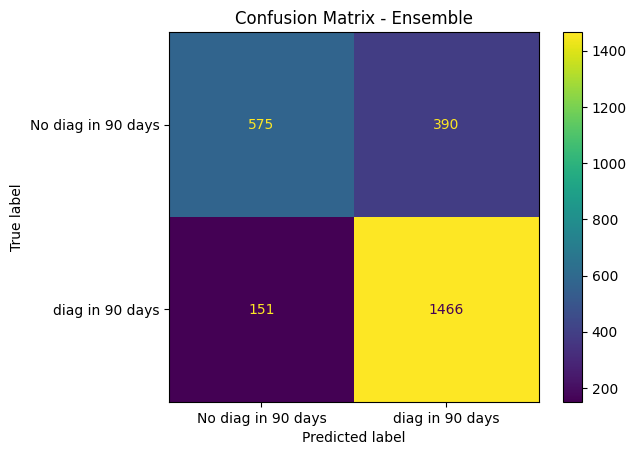

Ensemble Model Accuracy: 0.7904725019364833


In [18]:
# Assuming you have a RandomForestClassifier named 'rf_model'
class_weights = [1, 1] 
model2 = CatBoostClassifier(iterations=2000, verbose=400,  learning_rate=0.06, class_weights=class_weights)
model2.fit(train_pool, eval_set=val_pool, plot=True)

# XGBoost model
# xgb_model = XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=6)
# xgb_model.fit(X_train, y_train)

# logreg_model = LogisticRegression()
# logreg_model.fit(X_train, y_train)

# ensemble_model = VotingClassifier(
#     estimators=[
#         ('catboost', model2),
# #         ('logreg', logreg_model),
# # #         ('xgboost', xgb_model),
# #         ('lgbm', lgbm_model)
#     ],
#     voting='hard'  # 'hard' for majority voting, 'soft' for weighted voting
# )

# Create a pipeline with the column transformer and the ensemble model
# ensemble_pipeline = Pipeline([
#     ('preprocessor', multicolumn_prep),
#     ('model', ensemble_model)
# ])

pipeline = Pipeline([
    ('preprocessor', multicolumn_prep),
    ('model', model2)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
predictions_ensemble = pipeline.predict(X_val)

# Calculate confusion matrix and display
cm_ensemble = confusion_matrix(y_val, predictions_ensemble)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['No diag in 90 days', 'diag in 90 days'])
disp_ensemble.plot()
plt.title('Confusion Matrix - Ensemble')
plt.show()

# Evaluate the ensemble model on the testing data
accuracy_ensemble = pipeline.score(X_val, y_val)
print(f'Ensemble Model Accuracy: {accuracy_ensemble}')


In [19]:


# Use the trained pipeline to predict on the test data
predictions = pipeline.predict(test_data)

test_data.set_index('patient_id', inplace=True)

# Assuming you want to add the predictions back to your test dataset
test_data['DiagPeriodL90D'] = predictions


submission = test_data['DiagPeriodL90D']

# Save the submission to a CSV file
submission.to_csv('submission.csv')
